## Plot Figures 1 (map) 2 (timelines) 3 (spectra/ograms) 4 (specufoec workflow)

These depict the input data , preprocessing, SpecUFEx workflow

For Sawi et al., 2022


In [137]:
import os

import sys


import h5py

import pandas as pd

import numpy as np

from matplotlib import pyplot as plt

from matplotlib import cm

import matplotlib.gridspec as gridspec

import matplotlib.image as mpimg

from scipy.io import loadmat
import scipy


import datetime as dtt

import datetime



sys.path.append('.')
sys.path.append('./functions')

import paths



from functions2 import dateToEventID, getDailyTempDiff, getFeatures, getLocationFeatures,getNMFOrder,resortByNMF,getSpectra_fromWF,getSgram,PCAonFP,calcSilhScore,getSpectraMedian,CalcDiffPeak,PVEofPCA,getTopFCat,calcFFT, getWF, swapLabels,trimSpectra, KMeansSpectra, compileSpectraFromWF
import figureFunctions2



from functions2 import getFeatures, getLocationFeatures,getNMFOrder,resortByNMF,getSpectra_fromWF,getSgram
from functions2 import PCAonFP,calcSilhScore,getDailyTempDiff,getSpectraMedian,CalcDiffPeak,PVEofPCA,getTopFCat 
from functions2 import catMergeFromH5, swapLabels, calcFFT, getWF, swapLabels,trimSpectra, KMeansSpectra, compileSpectraFromWF
import figureFunctions2

## Set paths

In [4]:
#%% load project variables: names and paths


key = "BB_Gorner_Event_Redo_v2"
keyN = "BB_Gorner_Cont_Redo_v5"


filetype = '.gse2'     
filetypeN = '.sac' 


p = paths.returnp(key)
pN = paths.returnp(keyN)

#%%

projName        = p['projName']
datasetID       = p['datasetID']
projName        = p['projName']
station         = p['station']
channel         = p['channel']
path_top        = p['path_top']
path_proj       = p['path_proj']
outfile_name    = p['outfile_name']
dataFile_name   = p['dataFile_name']
path_WF         = p['path_WF']
path_Cat        = p['path_Cat'] #original, raw catalog
subCatalog_Name = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"



pathFP          = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_FEATout/'
pathACM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEB          = f'{path_top}{projName}/02_src/02_SpecUFEx/EB.mat'
pathElnB          = f'{path_top}{projName}/02_src/02_SpecUFEx/ElnB.mat'
pathW        = path_proj + '02_src/02_SpecUFEx/out.DictGain.mat' 


# pathClusCat = path_proj + f"principalDf_full_{mode}_Kopt{Kopt}.csv"
dataH5_path = path_proj + dataFile_name


projNameN        = pN['projName']
datasetIDN       = pN['datasetID']
projNameN        = pN['projName']
station          = pN['station']
channel          = pN['channel']


path_top         = pN['path_top']
path_projN       = pN['path_proj']
outfile_nameN    = pN['outfile_name']
dataFile_nameN   = pN['dataFile_name']
path_WFN         = pN['path_WF']
path_CatN        = pN['path_Cat'] #original, raw catalog
subCatalog_NameN = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"


pathACMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/EB.mat'
pathElnBN        = f'{path_top}{projNameN}/02_src/02_SpecUFEx/ElnB.mat'
pathWN           = path_projN + '02_src/02_SpecUFEx/out.DictGain.mat' 

path_WFN         = pN['path_WF']


# pathClusCatN = path_projN + f"principalDf_full_{mode}_Kopt{KoptN}.csv"
dataH5_pathN = path_projN + dataFile_nameN

pathFig = '../05_reports/figures/'
pathFigSupp = '../05_reports/supp_figures/'
pathAuxData = '../01_input/data/processed/Garcia/'

## Load auxiliary catalog

In [5]:
## Load auxiliary catalog

gps_station_list = ['24','34','36','37']
gps_df_list = []

for gst in gps_station_list:
    
    
    gps_df = pd.read_csv(f'{pathAuxData}gps_roll_Slopecorrected_{gst}.csv',index_col=0)
    gps_df['datetime'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df['datetime_index'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df = gps_df.set_index('datetime_index')
    
    
    gps_df_list.append(gps_df)


lake_df = pd.read_csv(f'{pathAuxData}lake_df.csv',index_col=0)
lake_df['datetime'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df['datetime_index'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df = lake_df.set_index('datetime_index')


meteor_df = pd.read_csv(f'{pathAuxData}meteor_df.csv',index_col=0)
meteor_df['datetime'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df['datetime_index'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df = meteor_df.set_index('datetime_index')

rain_df = meteor_df.rain


## Define some important times in study period

In [6]:
# timing of lake events 
tstart = dtt.datetime(2007, 6, 13)
tend = dtt.datetime(2007, 7, 23)
calvet = dtt.datetime(2007, 7, 1,13,41,35)
supraDraint = dtt.datetime(2007, 7, 4)
subDraint = dtt.datetime(2007, 7, 7)
drainEndt = dtt.datetime(2007, 7, 15)


## Load original catalogs

In [9]:
cat00 = catMergeFromH5(path_Cat,path_proj,outfile_name)
cat00N = catMergeFromH5(path_CatN,path_projN,outfile_nameN)




1457 events kept, merge sucessful
1472 events kept, merge sucessful


## Load station data

In [12]:
##station data 
stn = pd.read_csv("../01_input/data/raw/stnlst.csv",
                  header=None,
                  names=['name','X','Y','Elevation','dX','dY','Depth'])

        

## Get experiment parameters from H5 file

In [13]:
#########       #########       #########       #########       #########       #########       #########       #########       

####IQIQIQIQIQIQIQIQI

#########       #########       #########       #########       #########       #########       #########       #########       



with h5py.File(path_proj + dataFile_name,'r') as dataFile:

    lenData = dataFile['processing_info/'].get('lenData')[()]
    fs = dataFile['spec_parameters/'].get('fs')[()]
    
    # fmin = 
    nperseg = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlap = dataFile['spec_parameters/'].get('noverlap')[()]
    nfft = dataFile['spec_parameters/'].get('nfft')[()]


    fmax = dataFile['spec_parameters/'].get('fmax')[()]
    fmax = np.ceil(fmax)
    fmin = dataFile['spec_parameters/'].get('fmin')[()]
    fmin = np.floor(fmin)    

    
    sgram_mode = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scaling = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
with h5py.File(path_proj + outfile_name,mode='a') as sub_catalog_h5:
    fSTFT = sub_catalog_h5['spec_parameters/'].get('fSTFT')[()]
    tSTFT = sub_catalog_h5['spec_parameters/'].get('tSTFT')[()] 
    
        
fs = int(np.ceil(fs))
winLen_Sec = float(nperseg / fs)


#########       #########       #########       #########       #########       #########       #########       #########       

##### NOISENOISENOISENOISENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


with h5py.File(path_projN + dataFile_nameN,'r') as dataFile:

    lenDataN = dataFile['processing_info/'].get('lenData')[()]
    fsN = dataFile['spec_parameters/'].get('fs')[()]
    
    npersegN = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlapN = dataFile['spec_parameters/'].get('noverlap')[()]
    nfftN = dataFile['spec_parameters/'].get('nfft')[()]


    fmaxN = dataFile['spec_parameters/'].get('fmax')[()]
    fmaxN = np.ceil(fmaxN)
    fminN = dataFile['spec_parameters/'].get('fmin')[()]
    fminN = np.floor(fminN)    
    fSTFTN = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFTN = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_modeN = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scalingN = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fsN = int(np.ceil(fsN))
winLen_SecN = float(npersegN / fsN)



## Load specufex output

In [15]:

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - IQIQIQIQIQIQIQIQIQIQ
 
#########       #########       #########       #########       #########       #########       #########       #########       Wmat = loadmat(pathW)

## specufex parameters
Wmat = loadmat(pathW)
EBmat = loadmat(pathEB)

W = Wmat.get('W1')
EB = EBmat.get('EB')



numPatterns = len(W[1])
Nfreqs = len(W)
numStates = EB.shape[0]



order_swap = getNMFOrder(W,numPatterns)
W_new = resortByNMF(W,order_swap)
EB_new = resortByNMF(EB,order_swap)

RMM = W_new @ EB_new.T

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - NOISENOISENOINSENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


WmatN = loadmat(pathWN)
EBmatN = loadmat(pathEBN)

WN = WmatN.get('W1')
EBN = EBmatN.get('EB')



numPatternsN = len(WN[1])
NfreqsN = len(WN)
numStatesN = EBN.shape[0]


order_swapN = getNMFOrder(WN,numPatternsN)
W_newN = resortByNMF(WN,order_swapN)
EB_newN = resortByNMF(EBN,order_swapN)

RMMN = W_newN @ EB_newN.T

## Format day ticks, time plotting

* Central European Time is 2 hours later than UTC (Coordinated Universal Time) 
* Max temp occurs around 16:00 (4pm) local time or, 14:00 (2pm) UTC
* All times in UTC

In [16]:


############################################################
            ##### FORMAT DAY TICKS (ASSUMES NO DAYS SKIPPED?) ######
############################################################
tstart = pd.to_datetime('2007-06-14 00:00:00')
tend   = pd.to_datetime('2007-07-22 00:00:00')



delta_day = 7

##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat00.event_ID.resample('D', label='left', closed='right').count()

numDays = len(clus_clu_perday)

days_list = [clus_clu_perday.index[i] for i in range(numDays)]


## these have lots of possible text formats
day_labels = [f"{days_list[d].month}-{days_list[d].date().day}" for d in range(0,len(days_list),delta_day)]

day_ticks = [days_list[d] for d in range(0,len(days_list),delta_day)]


# Central European Time is 2 hours later than UTC (Coordinated Universal Time)
##max temp is around 4pm local time or 16:00, in UTC it is 14:00 or 2pm

#all times in UTC
hour_of_approx_max_temp = 14
# hourMaxTemp = [dtt.datetime(2007, 6, 14,hour_of_approx_max_temp,0,0) + pd.DateOffset(i) for i in range(0,numDays)]


## ts 2021/08/07 : change line to start of day
dayStart = hourMaxTemp = [dtt.datetime(2007, 6, 14) + pd.DateOffset(i) for i in range(0,numDays)]

hour24labels = [str(r) for r in range(0,24)] #UTC

print(day_labels)
############################################################
############################################################

       

['6-14', '6-21', '6-28', '7-5', '7-12', '7-19']


In [17]:
plt.rcParams['image.cmap']='magma'

plt.rcParams.update({'font.size': 8})
colors =cm.Paired(np.array([1,5,7,9,2,4,6,8]))


## when plotting, add a bit of buffer so bars aren't cut off
tlimstart = pd.to_datetime('2007-06-13 12:00:00')
tlimend   = pd.to_datetime('2007-07-22 12:00:00')


lw1=4        
lw2=5
alphaT=1
ylabfont=8
ylabpad =10


plt_kwargs = {'lw1':lw1,
              'lw2':lw2,
              'alphaT':alphaT,
              'ylabfont':ylabfont,
              'ylabpad':ylabpad,
              'colors':colors,
              'scaling':scaling,
              'sgram_mode':sgram_mode,
              'hour24labels':hour24labels,
              'day_ticks':day_ticks,
              'day_labels':day_labels,
              'numDays':numDays,
              'hourMaxTemp':hourMaxTemp,
              'tstart':tlimstart, ## for extending x axis to fit bars
              'tend':tlimend,     ## for extending x axis to fit bars
              'tstartreal':tstart,## actual study bound
              'tendreal':tend     ## actual study bound
             }

## Specs for figures JGR

In [18]:
#quarter page
width1 = 3.74016
height1 = 4.52756

#full page
width2 = 7.48031
height2 = 9.05512

# Figure 1 - Icequake map with depth 

## Swiss map inlay

In [140]:
# img = mpimg.imread('map_CH.jpeg')
img_orig = mpimg.imread('Garcia_et_al_Fig1_for_Theresa.jpg')


# fig,ax2 = plt.subplots(figsize = (width2,3.38))#,sharex=True,constrained_layout=True)
# # plot Swiss map
# ax2.imshow(img_orig)
# ax2.axis('off')
# plt.savefig(pathFig + 'swissmap.png',dpi=300)


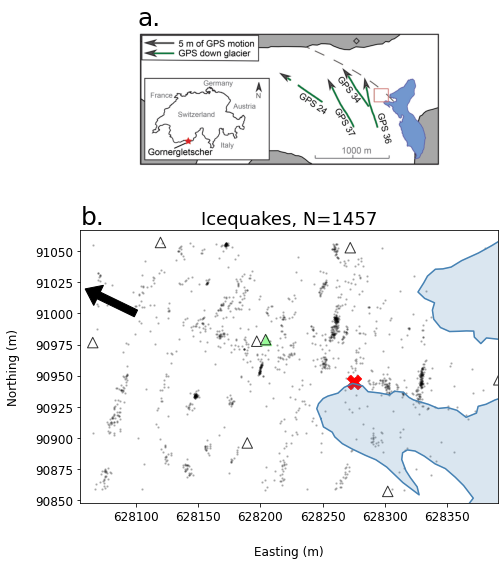

In [141]:
##v2
##settings for yellow bars
plt.rcParams.update({'font.size': 12})




fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True,constrained_layout=True)
gs = gridspec.GridSpec(3,1)





## plot Map of icequakes
ax = plt.subplot(gs[1:,:])    
figureFunctions2.plotMap(cat00,ax=ax,colorBy='all',size=2,alpha=.2,**plt_kwargs); #'cluster';'all';'datetime'
figureFunctions2.plotStations(stn,station,size=110,ax=ax)

##set map limits
buff = 10
ax.set_xlim(cat00.X_m.min()-buff,cat00.X_m.max()+buff)
ax.set_ylim(cat00.Y_m.min()-buff,cat00.Y_m.max()+buff)
ax.set_aspect('equal')


### ax.set_xticks([])
# ax.set_xticklabels('')

ax.set_ylabel('Northing (m)',labelpad=15,fontsize=12)

title = f'Icequakes, N={len(cat00)}'    
ax.set_title(title, pad=6,fontsize=18) 
ax.set_xlabel('Easting (m)',labelpad=22,fontsize=12)

## flow arrow
x = 628100
y = 91000
dx = -60 / 2
dy = 29 / 2
ax.arrow(x, y, dx, dy,color='k',width=6,head_length=12)



## plot approximate moulin location

mx = 628275
my = 90945
plt.scatter(mx,my,marker='X',s=200,color='r',label='Moulin')




###plot Swiss map
## img = plt.imread(pathFig + 'swissmap.png')
## img = plt.imread('map_CH.jpeg')
ax1 = plt.subplot(gs[0,:])
ax1.imshow(img_orig)
ax1.axis('off')

# newax = fig.add_axes([.4,0.8,0.2,0.2], anchor='NE', zorder=1)
# newax.imshow(img_orig)
# newax.axis('off')

atext = 25 

# ax.text(628055,91190,'a.',fontsize=atext)
# ax.text(628055,91070,'b.',fontsize=atext)
ax1.set_title('a.',fontsize=atext,loc='left')
ax.set_title('b.',fontsize=atext,loc='left')

gs.update(wspace=.4, hspace=0.3)


plt.savefig(pathFig + f'Figure_1.png',bbox_inches='tight',dpi=300)


# Figure 2

#### Get daily temperature difference

In [25]:
dtf = pd.DateOffset(1) #offset pink labels above date bars
dailyTempDiff = getDailyTempDiff(meteor_df,**plt_kwargs)


./functions/functions2.py:391: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  temp_H = meteor_df1.temp.resample('H',loffset='30T').mean().ffill()
./functions/functions2.py:392: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  temp_D = meteor_df1.temp.resample('D',loffset='12H').mean().ffill()


# Season plot

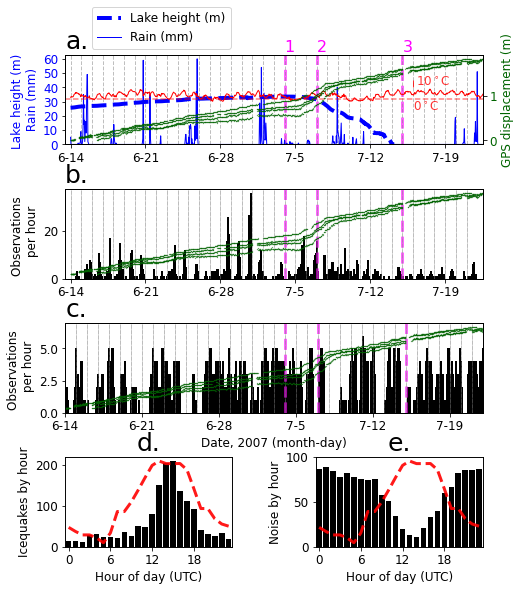

In [74]:
plt.figure(figsize=(width2,height2))
ax = plt.gca()

gs = gridspec.GridSpec(12,2)
gs.update(wspace=.5, hspace=100)

dtf = pd.DateOffset(0) #offset pink labels above date bars
Kopt=1

#title format
tpad = 5
tfont = 12

# bar width
bW = .2

## Labels and heights
title = f'              Icequakes, N={len(cat00)}'   
XX='IQ'#label for event line
ymax = 35
YY = 42
titleN = f'              Noise, N={len(cat00N)}'
XXN='NS'#label for event line
ymaxN = 17
YYN = 18 

## Plot aux geophyscial data
ax = plt.subplot(gs[0:3,:])


## plot temp
figureFunctions2.plotTemp(meteor_df.temp,ax=ax,**plt_kwargs)  

# pink lines for drainage stages
ax.axvline(supraDraint,color='fuchsia',ls='--',linewidth=3,alpha=.6)
ax.axvline(subDraint,color='fuchsia',ls='--',linewidth=3,alpha=.6)
ax.axvline(drainEndt,color='fuchsia',ls='--',linewidth=3,alpha=.6)

# text for drainage
yy = 64
fonts = 16
ax.text(supraDraint,yy+1,'1',color='fuchsia',fontsize=fonts,alpha=1)
ax.text(subDraint,yy+1,'2',color='fuchsia',fontsize=fonts,alpha=1)
ax.text(drainEndt,yy+1,'3',color='fuchsia',fontsize=fonts,alpha=1)

# day lines
for i in range(numDays):
    ax.axvline(hourMaxTemp[i],c='gray',linestyle='--',linewidth=1,alpha=.5)

    

# lake and rain
label='Lake height (m)'
labelR = 'Rain (mm)'
ax.set_ylabel('Lake height (m) \n Rain (mm) ',color='b')
ax.set_yticks(np.arange(0,61,10))
ax.set_yticklabels([f'{a:.0f}' for a in np.arange(0,61,10)])
[t.set_color('b') for t in ax.yaxis.get_ticklabels()]
ax.plot(lake_df.lake,c='b',lw=4,ls='--',label=label)

rain10 = rain_df * 10 #convert cm to mm
ax.plot(rain10,c='b',label=labelR,lw=1)
ax.set_xticks(day_ticks)
ax.set_xticklabels(day_labels)

## legend
ax.legend(bbox_to_anchor=(.05,1))

#xlabel
ax.set_xlabel('')
ax.set_xlim(tstart,tend)


#gps displ
for i, gps_dff in enumerate(gps_df_list):
    if i==0:
        figureFunctions2.plotGPS(gps_dff.gps_roll,size=.5,ax=ax,**plt_kwargs)
    else:
        figureFunctions2.plotGPS(gps_dff.gps_roll,size=.5,ylabel='none',ax=ax,**plt_kwargs)


# ax.set_xlabel('')   
# ax.set_xticklabels('')   

ax.set_ylim(ymin=0)


ax.set_title('a.',fontsize=atext,loc='left')

### ### ### ICEQUAKES ### ### ### 
### ### ### ICEQUAKES ### ### ### 
### ### ### ICEQUAKES ### ### ### 
### ### ### ICEQUAKES ### ### ### 
### ### ### ICEQUAKES ### ### ### 



## Bar plot, Temp and Lake/Precip
ax = plt.subplot(gs[3:6,:])

#lines for drainage
ax.axvline(supraDraint,color='fuchsia',ls='--',linewidth=3,alpha=.6)
ax.axvline(subDraint,color='fuchsia',ls='--',linewidth=3,alpha=.6)
ax.axvline(drainEndt,color='fuchsia',ls='--',linewidth=3,alpha=.6)

# ax.set_ylim(0,ymax)
ax.set_xlabel('Date, 2007 (month-day)',labelpad=6)
ax.set_xlim(tstart,tend)

figureFunctions2.plotBar(cat00,Kopt,barWidth=bW,timeBin='H',byCluster=False,ax=ax,**plt_kwargs)

for i, gps_dff in enumerate(gps_df_list):
    if i==0:
        figureFunctions2.plotGPS(gps_dff.gps_roll,size=.5,ylabel='none',ax=ax,**plt_kwargs)
    else:
        figureFunctions2.plotGPS(gps_dff.gps_roll,size=.5,ylabel='none',ax=ax,**plt_kwargs)

for i in range(numDays):
    ax.axvline(hourMaxTemp[i],c='gray',linestyle='--',linewidth=1,alpha=0.3) 

    YY = 39


ax.set_title(title, pad=tpad,fontsize=tfont,loc='left')
ax.set_xlabel('')   
# ax.set_xticklabels('')   
ax.set_ylim(0,38)

ax.set_title('b.',fontsize=atext,loc='left')    
### ### ### NOISE ### ### ### 
### ### ### NOISE ### ### ### 
### ### ### NOISE ### ### ### 
### ### ### NOISE ### ### ### 
### ### ### NOISE ### ### ### 

## Bar plot, Temp and Lake/Precip
ax = plt.subplot(gs[6:9,:])

#gps displ
for i, gps_dff in enumerate(gps_df_list):
    if i==0:
        figureFunctions2.plotGPS(gps_dff.gps_roll,size=.5,ax=ax,ylabel='none',**plt_kwargs)
    else:
        figureFunctions2.plotGPS(gps_dff.gps_roll,size=.5,ylabel='none',ax=ax,**plt_kwargs)


#lines for drainage
ax.axvline(supraDraint,color='fuchsia',ls='--',linewidth=3,alpha=.6)
ax.axvline(subDraint,color='fuchsia',ls='--',linewidth=3,alpha=.6)
ax.axvline(drainEndt,color='fuchsia',ls='--',linewidth=3,alpha=.6)

figureFunctions2.plotBar(cat00N,1,barWidth=bW,timeBin='H',byCluster=False,ax=ax,**plt_kwargs)


for i in range(numDays):
    ax.axvline(hourMaxTemp[i],c='gray',linestyle='--',linewidth=1,alpha=0.3) 

    
 # ax.set_ylim(0,ymaxN)
ax.set_xlabel('Date, 2007 (month-day)',labelpad=4)
ax.set_xlim(tstart,tend)


   
YYN = 7.2     
ax.set_title(titleN, pad=tpad,fontsize=tfont,loc='left')
ax.set_ylim(0,7)

ax.set_title('c.',fontsize=atext,loc='left')


########################
#### Icequakes by hour
########################

ax = plt.subplot(gs[9:,0])
figureFunctions2.plotHourBar(cat00,1,dailyTempDiff,ax=ax,label='none',labelpad=10,**plt_kwargs)
ax.set_xlabel('')
ax.set_xlabel('Hour of day (UTC)')
ax.set_yticks([0,100,200])
ax.set_yticklabels(['0','100','200'])
ax.set_ylabel('Icequakes by hour')

########################
#### Noise by hour
########################

ax2 = plt.subplot(gs[9:,1])
ax2.set_ylabel('Noise by hour')
figureFunctions2.plotHourBar(cat00N,1,dailyTempDiff,ax=ax2,label='none',labelpad=10,**plt_kwargs)
ax2.set_xlabel('Hour of day (UTC)')
ax2.set_yticks([0,50,100])
ax2.set_yticklabels(['0','50','100'])


## text labels
atext = 25 
# ax.text(-3,1175,'a.',fontsize=atext)
# ax.text(-3,850,'b.',fontsize=atext)
# ax.text(-3,530,'c.',fontsize=atext)
# ax.text(0,155,'d.',fontsize=atext)
# ax2.text(0,70,'e.',fontsize=atext,color='w')

ax.set_title('d.',fontsize=atext)#,loc='left')
ax2.set_title('e.',fontsize=atext)#,loc='left')


plt.savefig(pathFig + f'02_timing.png',dpi=300,bbox_inches='tight')

## Figure 3 


In [142]:

def getSpectra_fromWF3(evID,fs,fmin,fmax,dataH5_path,station,channel,normed=True):
## get WF from H5 and calc full sgram for plotting

    with h5py.File(dataH5_path,'r') as dataFile:

        wf_data = dataFile[f'waveforms/{station}/{channel}'].get(str(evID))[:]


    rollingf, rollingFFT =  calcFFT(wf_data,len(wf_data),fs,roll=100)
    
    if normed:
        rollingFFT = rollingFFT / np.median(rollingFFT)  ##norm by median
    else:
        rollingFFT = rollingFFT
        
    return rollingFFT, rollingf

# Calc spectra from FFT

In [127]:
calcSpectra = 1
if calcSpectra:
    list_rand_specMatsum = []
    for j,evID in enumerate(cat00.event_ID.iloc):

        rollingFFT, rollingf = getSpectra_fromWF3(int(evID),fs,fmin,fmax,dataH5_path,station,channel,normed=True)

        if j == 0:
            rollingFFT_sum = np.zeros(len(rollingFFT))
            rollingFFT_med = np.zeros(len(rollingFFT))



        rollingFFT_sum += rollingFFT

        rollingFFT_med = np.vstack([rollingFFT_med,rollingFFT])





    print(j+1)
    rollingFFT_med = np.median(rollingFFT_med,axis=0)
    sstd = np.std(rollingFFT_med,axis=0)



    list_rand_specMatsumN = []
    for jN,evID in enumerate(cat00N.event_ID.iloc):
        
        try:
            rollingFFTN, rollingfN = getSpectra_fromWF3(int(evID),fs,fminN,fmaxN,dataH5_pathN,station,channel,normed=True)

            if jN == 0:
                rollingFFT_sumN = np.zeros(len(rollingFFTN))
                rollingFFT_medN = np.zeros(len(rollingFFTN))


            rollingFFT_sumN += rollingFFTN

            rollingFFT_medN = np.vstack([rollingFFT_medN,rollingFFTN])
        except:
            continue

    print(jN+1)
    rollingFFT_medN = np.median(rollingFFT_medN,axis=0)
    sstdN = np.std(rollingFFT_medN,axis=0)



1457
1472


## show waveforms, not spectra

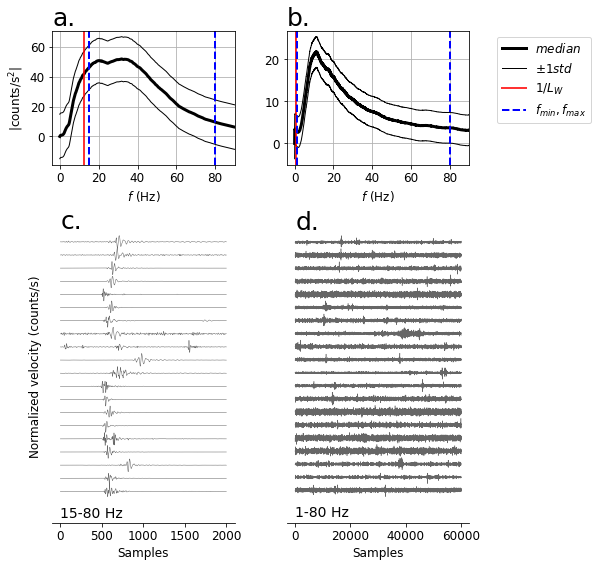

In [143]:

plt.rcParams.update({'font.size': 12})


fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True,constrained_layout=True)
gs = gridspec.GridSpec(6, 6)
gs.update(wspace=2, hspace=1)




lw=1
alpha=1


tfont=15
flabel1 = 60

FS = 14#font size for fmin and fmax
ymax = 1800
ymaxN = 3500



#### ICEQUAKE waveforms 

axs = plt.subplot(gs[2:,0:3],ymargin=.1)


Nids = 20

rand_ev = list(np.random.choice(cat00.event_ID,Nids,replace=False))

for i, evID in enumerate(rand_ev):


    wf = getWF(str(evID),dataH5_path,station,channel,fmin,fmax,fs)

    #Norm by max and zero mean
    wf_norm = wf / np.max(np.abs(wf))
    wf_zeromean = wf_norm - np.mean(wf_norm)
    
    offset = 2
    wf_offset = (wf_zeromean) + i*offset#1.5
        ##plot !!

    plt.plot(wf_offset,lw=.5,alpha=.6,c='k')

        

datte = str(pd.to_datetime('200' + str(evID)).date())[2:]
timme = str(pd.to_datetime('200' + str(evID)).time())


axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.spines['bottom'].set_visible(False)    
axs.set_yticks([]) 
axs.set_yticklabels([])     
axs.set_xlabel('Samples',labelpad=4)


axs.text(0,40,'c.',fontsize=atext)



axs.set_ylabel('Normalized velocity (counts/s)',labelpad=10)
axs.text(-2,-4,f'{int(fmin)}-{int(fmax)} Hz',fontsize=14)
axs.spines['bottom'].set_visible(True)    


#### waveforms NOISE

axs = plt.subplot(gs[2:,3:],ymargin=.1)


Nids = 20

rand_ev = list(np.random.choice(cat00N.event_ID,Nids,replace=False))

for i, evID in enumerate(rand_ev):


    wf = getWF(str(evID),dataH5_pathN,station,channel,fminN,fmaxN,fsN)

    #Norm by max and zero mean
    wf_norm = wf / np.max(np.abs(wf))
    wf_zeromean = wf_norm - np.mean(wf_norm)
    
    offset = 2
    wf_offset = (wf_zeromean) + i*offset#1.5
        ##plot !!

    plt.plot(wf_offset,lw=.5,alpha=.6,c='k')

        

datte = str(pd.to_datetime('200' + str(evID)).date())[2:]
timme = str(pd.to_datetime('200' + str(evID)).time())


axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.spines['bottom'].set_visible(False)    
axs.set_yticks([]) 
axs.set_yticklabels([])     
axs.set_xlabel('Samples',labelpad=4)

axs.text(-2,-4,f'{int(fminN)}-{int(fmaxN)} Hz',fontsize=14)
axs.spines['bottom'].set_visible(True)  





axs.text(0,40,'d.',fontsize=atext)





## Icequakes Medians
ax = plt.subplot(gs[0:2,0:3])

# ax.set_ylabel('20*log10(|m/s$^2$|$^2$)')
ax.set_ylabel('|counts/s$^2$|')

ax.plot(rollingf,rollingFFT_med,c='k',label='$median$',lw=3)
ax.plot(rollingf,rollingFFT_med+sstd,c='k',label='$\pm1 std$',lw=1)
ax.plot(rollingf,rollingFFT_med-sstd,c='k',lw=1)

ax.axvline(x=1/winLen_Sec,color='r',label='$1/L_{W}$',lw=2,alpha=.8)  
ax.axvline(x=fmin,color='blue',ls='--',lw=2)
ax.axvline(x=fmax,color='blue',ls='--',lw=2)



ax.set_xlabel('$f$ (Hz)')
# # ax.set_xlim(-5,300)
ax.set_xlim(fminN-5,fmax+10)
# ax.set_ylim(0,2000)
# ax.set_yticklabels(['500','1000','1500','2000'])
# ax.set_yticks([500,1000,1500,2000])     


plt.grid()
ax.set_title('a.',fontsize=atext,loc='left',pad=0)


###### NOISE #####
ax = plt.subplot(gs[0:2,3:])

ax.plot(rollingfN,rollingFFT_medN,c='k',label='$median$',lw=3)
ax.plot(rollingfN,rollingFFT_medN+sstdN,c='k',label='$\pm1 std$',lw=1)
ax.plot(rollingfN,rollingFFT_medN-sstdN,c='k',lw=1)


flabel1N = flabel1

ax.axvline(x=1/winLen_SecN,color='r',label='$1/L_{W}$',lw=2,alpha=.8)  
ax.axvline(x=fminN,color='blue',ls='--',lw=2,label='$f_{min},f_{max}$')
ax.axvline(x=fmaxN,color='blue',ls='--',lw=2)
ax.set_title('b.',fontsize=atext,loc='left', pad=0)


ax.set_xlabel('$f$ (Hz)')
ax.set_xlim(fminN-5,fmaxN+10)
# ax.set_ylim(0,2000)
# ax.set_yticklabels(['500','1000','1500','2000'])
# ax.set_yticks([500,1000,1500,2000])     


ax.legend(loc='upper right',bbox_to_anchor=(1.7,1))


plt.grid()



plt.savefig(pathFig + f'4_inputData.png',dpi=300,bbox_inches='tight')

# Figure 4 - SpecUFEx Workflow and Reconstructing Spectra

## Workflow components (assemble in photoshop)

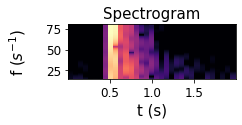

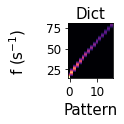

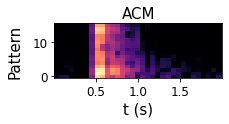

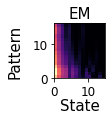

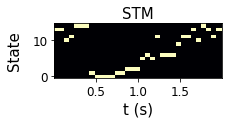

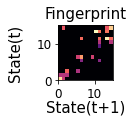

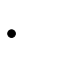

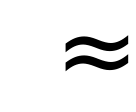

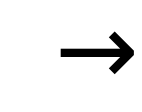

In [95]:
## Plot components 


evID = '70620173028'
LFS = 15

##SGram
fig,ax = plt.subplots(figsize = (width2//2,height1//4))#,sharex=True,constrained_layout=True)
specMat,x = getSgram(path_proj,evID,station)
plt.pcolormesh(tSTFT, fSTFT, specMat,cmap=cm.magma, shading='auto')
# date_title = str(pd.to_datetime('200' + evID))
ax.set_ylabel('f ($s^{-1}$)',rotation=90,labelpad=18,fontsize=LFS)
ax.set_title('Spectrogram',pad=tpad+1,fontsize=tfont)
ax.set_xlabel('t (s)',fontsize=LFS)
plt.savefig(pathFig + f'sgram.png',bbox_inches='tight',dpi=300)



### NMF Dict
fig,ax = plt.subplots(figsize = (width2//4,height1//4))#,sharex=True,constrained_layout=True)
ax.set_title('Dict',pad=tpad,fontsize=tfont)
figureFunctions2.plotW(W_new,numPatterns,fSTFT,aspect=.3,ax=ax)
ax.set_ylabel('f (s$^{-1}$)',rotation=90,labelpad=18,fontsize=LFS)
ax.set_xlabel('Pattern',fontsize=LFS)
plt.savefig(pathFig + f'NMF_Dict.png',bbox_inches='tight',dpi=300)

##ACM
fig,ax = plt.subplots(figsize = (width2//2,height1//4))#,sharex=True,constrained_layout=True)
ax.set_title('ACM',pad=tpad,fontsize=tfont)
figureFunctions2.plotACM(evID, pathACM, order_swap,tSTFT,numPatterns,ax=ax)
ax.set_ylabel('Pattern',rotation=90,labelpad=10,fontsize=LFS)
ax.set_xlabel('t (s)',fontsize=LFS)
plt.savefig(pathFig + f'ACM.png',bbox_inches='tight',dpi=300)



##EM
fig,ax = plt.subplots(figsize = (width2//4,height1//4))#,sharex=True,constrained_layout=True)
figureFunctions2.plotEB(EB_new,aspect=1,ax=ax)
ax.set_title('EM',pad=tpad,fontsize=tfont)
ax.set_xlabel('State',labelpad=0,fontsize=LFS)
ax.set_ylabel('Pattern',rotation=90,labelpad=10,fontsize=LFS)
plt.savefig(pathFig + f'EM.png',bbox_inches='tight',dpi=300)


##STM
fig,ax = plt.subplots(figsize = (width2//2,height1//4))#,sharex=True,constrained_layout=True)
figureFunctions2.plotSTM(evID, pathSTM,tSTFT,ax=ax)
ax.set_title('STM',pad=tpad,fontsize=tfont)
ax.set_ylabel('State',rotation=90,labelpad=10,fontsize=LFS)
ax.set_xlabel('t (s)',fontsize=LFS)
plt.savefig(pathFig + f'STM.png',bbox_inches='tight',dpi=300)




##FP
fig,ax = plt.subplots(figsize = (width2//4,height1//4))#,sharex=True,constrained_layout=True)
ax.set_title('Fingerprint',pad=tpad+2,fontsize=tfont)
figureFunctions2.plotFP(path_proj,outfile_name,evID,ax=ax)
ax.set_aspect('equal')
ax.set_ylabel('State(t)',rotation=90,labelpad=14,fontsize=LFS)
ax.set_xlabel('State(t+1)',rotation=0,labelpad=0,fontsize=LFS)
plt.savefig(pathFig + f'fp.png',bbox_inches='tight',dpi=300)



###Math symbols
fig,ax = plt.subplots(figsize = (width2//4,height1//4))#,sharex=True,constrained_layout=True)
circle1 = plt.Circle((0.08, 0.5), 0.07, color='k')
ax.add_patch(circle1)
ax.set_aspect('equal')
ax.axis('off')
plt.savefig(pathFig + f'dot.png',bbox_inches='tight',dpi=300)



fig,ax = plt.subplots(figsize = (width2//4,height1//4))#,sharex=True,constrained_layout=True)
ax.text(.5,.4,r'$\approx$',fontsize=100)
ax.axis('off')
plt.savefig(pathFig + f'approx.png',bbox_inches='tight',dpi=300)


fig,ax = plt.subplots(figsize = (width2//4,height1//4))#,sharex=True,constrained_layout=True)
ax.text(.5,.4,r'$\rightarrow$',fontsize=100)
ax.axis('off')
plt.savefig(pathFig + f'arrow.png',bbox_inches='tight',dpi=300)


